# **Deep Learning Lab: Transfer Learning**

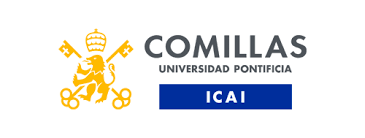

***

In [ ]:
!cat /proc/cpuinfo

cat: /proc/cpuinfo: No such file or directory


In [ ]:
!cat /proc/meminfo

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!nvidia-smi

In [ ]:
import tensorflow as tf

# Check GPU availability
print("GPU Available:", tf.test.is_gpu_available())

# Check TPU availability
tpu_available = False
devices = tf.config.list_logical_devices()
for device in devices:
    if device.device_type == 'TPU':
        tpu_available = True
        break

print("TPU Available:", tpu_available)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available: False
TPU Available: False


In [28]:
from google.colab import drive
drive.mount('/content/drive')

# Navigate to code directory
%cd /content/drive/My Drive/Google Colab/03TransferLearning

# List project directory contents
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: '/content/drive/My Drive/Google Colab/03TransferLearning'
/content
drive  sample_data


## Import packages

In [29]:
from importlib import reload  # Allows reloading user libraries
import sys
sys.path.append('/content/drive/My Drive/deep_learning_lab')
import cnn
from cnn import CNN
import torchvision
from cnn import load_data
from cnn import load_model_weights
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os
import json
reload(cnn)

<module 'cnn' from '/content/drive/My Drive/deep_learning_lab/cnn.py'>

## Model and data loading

In [31]:
# Pytorch has many pre-trained models that can be used for transfer learning
classification_models = torchvision.models.list_models(module=torchvision.models)
print(classification_models)

['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'googlenet', 'inception_v3', 'maxvit_t', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf', 'regnet_x_8gf', 'regnet_y_128gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf', 'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_8gf', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext101_64x4d', 'resnext50_32x4d', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflenet_v2_x2_0', 'squeezenet1_0

In [32]:
# Load data and model
train_dir = '/content/drive/My Drive/deep_learning_lab/dataset/training'
valid_dir = '/content/drive/My Drive/deep_learning_lab/dataset/validation'

train_loader, valid_loader, num_classes = load_data(train_dir,
                                                    valid_dir,
                                                    batch_size=32,
                                                    img_size=224) # ResNet50 requires 224x224 images
model = CNN(torchvision.models.resnet50(weights='DEFAULT'), num_classes)

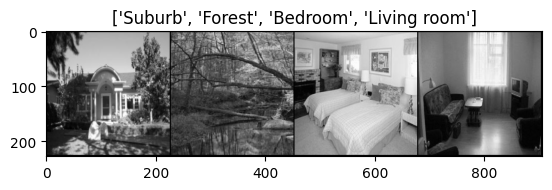

In [ ]:
# Visualize a few images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a few random images
random_indices = np.random.choice(len(valid_loader.dataset), size=4, replace=False)
inputs = []
classes = []
for i in random_indices:
    inputs.append(valid_loader.dataset[i][0])
    classes.append(valid_loader.dataset[i][1])
out = torchvision.utils.make_grid(inputs)
classnames = train_loader.dataset.classes
imshow(out, title=[classnames[x] for x in classes])

## Train

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
history = model.train_model(train_loader, valid_loader, optimizer, criterion, epochs=20)

Epoch 1/20 - Train Loss: 2.4480, Train Accuracy: 0.5142
Epoch 1/20 - Validation Loss: 2.3820, Validation Accuracy: 0.5587
Epoch 2/20 - Train Loss: 2.3506, Train Accuracy: 0.5759
Epoch 2/20 - Validation Loss: 2.3090, Validation Accuracy: 0.5893
Epoch 3/20 - Train Loss: 2.2883, Train Accuracy: 0.6067


In [ ]:
model.save_model('resnet50-1epoch')

## Predict

#### Load model

In [ ]:
# Load model
model_weights = load_model_weights('resnet50-1epoch')
my_trained_model = CNN(torchvision.models.resnet50(weights='DEFAULT'), num_classes)
my_trained_model.load_state_dict(model_weights)

<All keys matched successfully>

## Results

In [ ]:
predicted_labels = my_trained_model.predict(valid_loader)

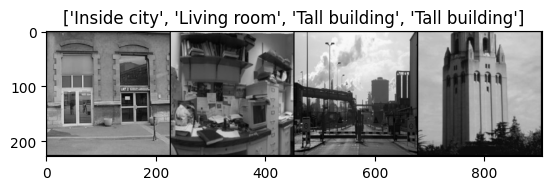

In [ ]:
# Get a few random images
random_indices = np.random.choice(len(valid_loader.dataset), size=4, replace=False)
inputs = []
classes = []
for i in random_indices:
    inputs.append(valid_loader.dataset[i][0])
    classes.append(predicted_labels[i])

out = torchvision.utils.make_grid(inputs)
classnames = train_loader.dataset.classes
imshow(out, title=[classnames[x] for x in classes])
